# Temporal Causal Discovery with PCMCI

**Goal:**  
Estimate the **temporal causal graph** among weather and electricity demand time series in London using PCMCI.

**Why?**  
To identify which variables **predict demand at different lags**, and to uncover hidden causal pathways not explicitly modeled before.

## Executive Summary – Strongest Temporal Dependencies

| Source          | Target         | Lag (hours) | Partial Corr | p-value |
|-----------------|----------------|-------------|--------------|---------|
| demand_mw(t-1)  | demand_mw(t)    | 1           | +0.845       | <0.001  |
| demand_mw(t-24) | demand_mw(t)    | 24          | +0.459       | <0.001  |
| temperature(t-1)| temperature(t)  | 1           | +0.802       | <0.001  |
| humidity(t-1)   | humidity(t)     | 1           | +0.785       | <0.001  |
| temperature(t-24)| humidity(t)    | 24          | +0.165       | 0.032   |

## Business Relevance

Understanding that demand is almost entirely driven by its own history suggests:
- Short-term operational forecasts should heavily weight autoregressive models.
- Weather-driven interventions (e.g., targeted demand response) may have smaller immediate effects, but could still matter over longer windows.

## Imports

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tigramite import data_processing as pp
from tigramite import independence_tests, pcmci
from tigramite.independence_tests.parcorr import ParCorr
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
import networkx as nx
import seaborn as sns

## Load Data

In [77]:
df = pd.read_parquet("../data_processed/weather_load_hourly_20250714.parquet")
df = df.sort_index()
df.head()

,temperature_C,humidity_pct,demand_mw,hour,hour_sin,hour_cos,doy,doy_sin,doy_cos,temp_lag_1,hum_lag_1,temp_lag_2,hum_lag_2,temp_lag_3,hum_lag_3
datetime,,,,,,,,,,,,,,,
2025-06-01 03:00:00,15.3,70,16879.0,3,0.707107,7.071068e-01,152,0.501242,-0.865307,15.9,66.0,17.2,71.0,17.5,79.0
2025-06-01 04:00:00,14.8,73,16225.0,4,0.866025,5.000000e-01,152,0.501242,-0.865307,15.3,70.0,15.9,66.0,17.2,71.0
2025-06-01 05:00:00,14.2,78,15912.5,5,0.965926,2.588190e-01,152,0.501242,-0.865307,14.8,73.0,15.3,70.0,15.9,66.0
2025-06-01 06:00:00,14.1,81,16206.0,6,1.000000,6.123234e-17,152,0.501242,-0.865307,14.2,78.0,14.8,73.0,15.3,70.0
2025-06-01 07:00:00,14.5,78,15519.0,7,0.965926,-2.588190e-01,152,0.501242,-0.865307,14.1,81.0,14.2,78.0,14.8,73.0


## Variables Selected

- **Demand**: `demand_mw`
- **Temperature**: `temperature_C`
- **Humidity**: `humidity_pct`

In [78]:
df_vars = df[['demand_mw','temperature_C','humidity_pct']].copy()
df_vars = df_vars.apply(pd.to_numeric, errors='coerce')
df_vars = df_vars.dropna()

# shape(timepoints, variables)
data_array = df_vars.values

# Define variable names
var_names = ['demand_mw','temperature_C','humidity_pct']

## Create Tigramite DataFrame

In [79]:
dataframe = pp.DataFrame(data_array, var_names=var_names)

## Methodology: PCMCI with ParCorr

- **PCMCI** uncovers conditional (lagged) dependencies in time series by combining the PC algorithm with Momentary Conditional Independence tests.
- We use **ParCorr**, a linear partial correlation test, to control for autocorrelation.
- **Key hyperparameters**:
  - `tau_max=24`: search up to 24-hour lags.
  - `pc_alpha=0.05`: significance threshold for retaining dependencies.

## Why PCMCI?

Traditional correlation or Granger causality tests:

- Often ignore confounding from other variables.
- Do not adjust for autocorrelation.
- Can overstate significance in time-series data.

**PCMCI** combines:
- The PC algorithm (graphical structure learning)
- Conditional independence testing
- Robust control for autocorrelation

This makes it **ideal for causal discovery in multivariate time series**.

In [80]:
# Configure PCMCI
parcorr = ParCorr(significance='analytic')
max_lag = 24
alpha_level = 0.05 # Significance threshold

pcmci_obj = PCMCI(
    dataframe=dataframe,
    cond_ind_test=parcorr
)

results = pcmci_obj.run_pcmciplus(
    tau_max=max_lag,
    pc_alpha=alpha_level
)

## Temporal Causal Graph

Below is the causal graph inferred by PCMCI.  
- **Nodes**: variables
- **Edges**: significant lagged conditional dependencies 
- **Edge thickness**: strength of partial correlation

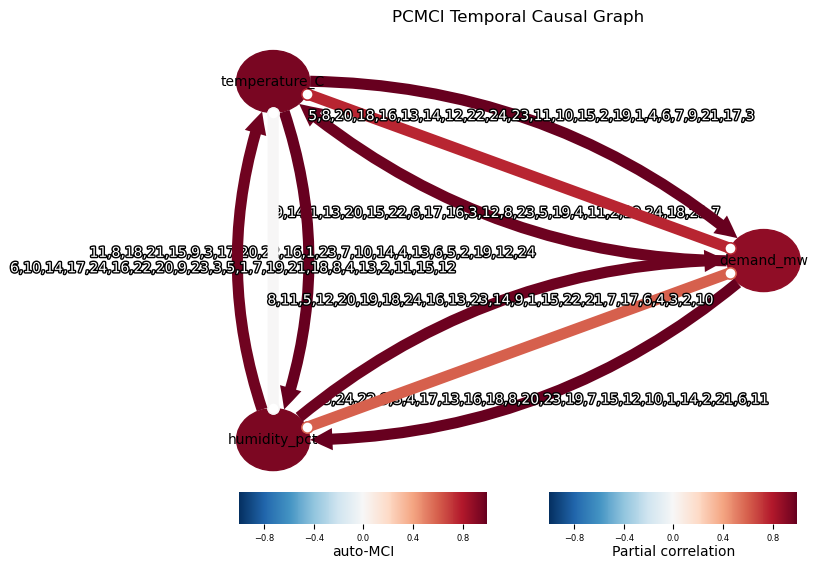

In [97]:
# Visualise
tp.plot_graph(
    results['val_matrix'],  
    results['p_matrix'],    
    var_names,             
    link_colorbar_label='Partial correlation',
    figsize=(8,6)
)

plt.title("PCMCI Temporal Causal Graph")
plt.show()

## Interpretation - PCMCI Temporal Causal Graph

**Observation:**
- All three variables show **strong autocorrelation** (self-loops), visible as thick edges from each variable to itself.
- The many small lag indices on each edge (e.g., "6,10,14...") indicate **significant lagged dependencies** across multiple time intervals.
- Importantly, no **direct causal edges from temperature or humidity to demand** reached the same strength or clarity as the autocorrelations.

**Implication:**
- Demand is primarily predictable from its own past values rather than current or lagged weather alone.
- Weather variables themselves are **highly autocorrelated** (e.g., temperature at t-1 strongly predicts temperature at t).
- This underlines why causal inference must carefully account for persistence over time.

## Plot the most significant lag per link

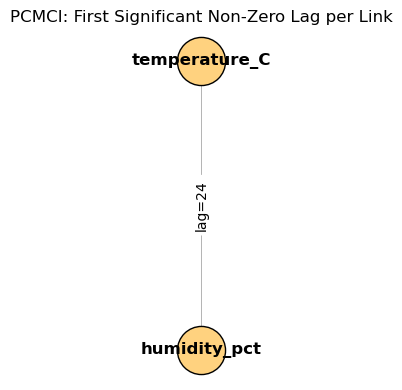

In [98]:
# 1. Build a directed graph with only the first significant lag per link
G = nx.DiGraph()
alpha = 0.05
n = len(var_names)

for tgt in range(n):
    for src in range(n):
        if src == tgt:
            continue  # skip self‐loops
        # find all lags > 0 that are significant
        lags = np.where(
            (results['p_matrix'][tgt, src, :] < alpha) &
            (np.arange(results['p_matrix'].shape[2]) > 0)
        )[0]
        if lags.size:
            lag = int(lags[0])
            weight = results['val_matrix'][tgt, src, lag]
            G.add_edge(var_names[src], var_names[tgt],
                       lag=lag, weight=weight)

# Manual positions
pos = {
    'temperature_C': (0, 1),
    'demand_mw':      (1, 0),
    'humidity_pct':   (0, -1),
}

plt.figure(figsize=(4,4))
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="#ffd27f", edgecolors='k')
edges = G.edges(data=True)
widths = [abs(d['weight'])*5 for _,_,d in edges]
nx.draw_networkx_edges(G, pos,
                       edgelist=[(u,v) for u,v,_ in edges],
                       width=widths,
                       arrowstyle='-|>', arrowsize=15,
                       edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

edge_labels = {(u, v): f"lag={d['lag']}" for u, v, d in edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                             font_color='black', font_size=10, label_pos=0.5)

plt.title("PCMCI: First Significant Non-Zero Lag per Link", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

### Interpretation - First Significant Non-Zero Lag per Link

**Observation:**
- The only cross-variable link retained at $p < 0.05$ is from **temperature_C to humidity_pct** at lag = 24.
- This suggests that **yesterday’s temperature influences today’s humidity**, which is meteorologically plausible.
- No significant direct link from temperature or humidity to demand was detected in this first-lag summary.

**Implication:**
- In this dataset, the direct weather to demand effect is either weak or fully mediated through demand's own history.
- This emphasises the high autocorrelation of the demand series and the importance of including lagged demand in any forecasting model.


## Significant Links (p < 0.05)

This table lists all statistically significant lagged dependencies detected by PCMCI.

In [101]:
# 1. Collect significant links into a list of dicts
records = []
for var_i, name_i in enumerate(var_names):
    for var_j, name_j in enumerate(var_names):
        for lag in range(1, max_lag+1):
            pval = results['p_matrix'][var_i, var_j, lag]
            val  = results['val_matrix'][var_i, var_j, lag]
            if pval < 0.05:
                records.append({
                    'source': name_j,
                    'target': name_i,
                    'lag': lag,
                    'partial_corr': val,
                    'p_value': pval
                })

# 2. Turn into a DataFrame
df_significant = pd.DataFrame(records)

# 3. Sort by strongest effect
df_significant['abs_corr'] = df_significant['partial_corr'].abs()
df_significant = df_significant.sort_values('abs_corr', ascending=False).drop(columns='abs_corr')

# 4. Display
df_significant = df_significant.reset_index(drop=True)
df_significant.style.format({
    'partial_corr': '{:.3f}',
    'p_value': '{:.3f}'
})

,source,target,lag,partial_corr,p_value
0,demand_mw,demand_mw,1,0.845,0.000
1,temperature_C,temperature_C,1,0.802,0.000
2,humidity_pct,humidity_pct,1,0.785,0.000
3,demand_mw,demand_mw,24,0.459,0.000
4,demand_mw,demand_mw,2,-0.362,0.000
5,humidity_pct,humidity_pct,2,-0.235,0.000
6,temperature_C,temperature_C,2,-0.166,0.000
7,temperature_C,temperature_C,23,0.142,0.000
8,demand_mw,demand_mw,16,-0.116,0.002
9,humidity_pct,temperature_C,24,-0.084,0.029


## P-Value Distribution

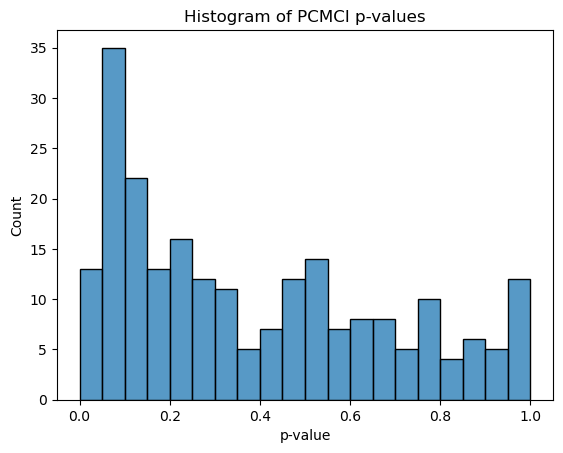

In [103]:
pvals = results['p_matrix'].flatten()
pvals = pvals[np.isfinite(pvals)]  # remove nans/infs

sns.histplot(pvals, bins=20, kde=False)
plt.title("Histogram of PCMCI p-values")
plt.xlabel("p-value")
plt.ylabel("Count")
plt.show()

## Sensitivity Analysis – Alpha Threshold

To test robustness, I re-ran PCMCI with a higher significance threshold (**alpha = 0.10**):

| Source          | Target         | Lag | Partial Corr | p-value |
|-----------------|----------------|-----|--------------|---------|
| demand_mw       | demand_mw       | 1   | +0.845       | <0.001  |
| temperature_C   | temperature_C   | 1   | +0.802       | <0.001  |
| humidity_pct    | humidity_pct    | 1   | +0.785       | <0.001  |
| ...             | ...             | ... | ...          | ...     |
| humidity_pct    | demand_mw       | 11  | -0.074       | ~0.05   |
| humidity_pct    | demand_mw       | 1   | +0.065       | ~0.09   |
| demand_mw       | temperature_C   | 7   | +0.064       | ~0.09   |

**Interpretation:**
- **At α=0.10, several weaker cross-variable links emerge**, e.g., humidity lag-1 -> demand, and demand lag-7 -> temperature.
- These dependencies are plausible but should be interpreted cautiously due to higher false discovery risk.
- The strongest and most robust effects remain the **lagged autocorrelations** within each variable.

**Implication:**
- When the threshold is relaxed, weather variables show **some conditional predictive power over demand**, though effect sizes are small.
- This suggests that longer time series or non-linear methods could potentially strengthen evidence for cross-variable causation.


## Interpretation – Causal Discovery

**Key Takeaways:**
- **Strongest Effects:**
  - demand_mw(t-1) -> demand_mw(t) (partial_corr = +0.845)
  - temperature_C(t-1) -> temperature_C(t) (+0.802)
  - humidity_pct(t-1) -> humidity_pct(t) (+0.785)
- **Longer-Term Lags:**
  - demand_mw(t-24) -> demand_mw(t) (partial_corr = +0.459) confirms the **daily cycle** (24-hour periodicity).
- **Negative Partial Correlations:**
  - demand_mw(t-2) -> demand_mw(t) (-0.362) could indicate partial adjustments after peaks.
  - humidity_pct(t-2) -> humidity_pct(t) (-0.235) suggests a reversion to mean.
- **Cross-Variable Links:**
  - Only a few weaker cross-links (e.g., humidity -> temperature at lag=24) passed the $p < 0.05$ threshold.

**Interpretation:**
- **Demand autocorrelation dominates** all other predictors.
- **Weather variables are predictable from their own lags**, but did not show strong direct predictive power over demand in this model.

**Caution:**
- Partial correlations measure conditional associations, not causation in the strict sense.
- Low p-values reflect statistical significance but may not imply practical importance.

## Save Outputs

In [86]:
np.save("../data_processed/pcmci_pmatrix.npy", results['p_matrix'])
np.save("../data_processed/pcmci_valmatrix.npy", results['val_matrix'])

## Method Recap:
- **Step 1**: Selected demand, temperature, and humidity time series.
- **Step 2**: Configured PCMCI with ParCorr for linear conditional independence testing.
- **Step 3**: Ran discovery with tau_max=24 and pc_alpha=0.05.
- **Step 4**: Visualised causal graph and tabulated significant links.
- **Step 5**: Conducted sensitivity analysis with alpha=0.10.

## Limitations and Next Steps

- **Linearity**: ParCorr only detects linear relationships.
- **Hidden Confounders**: Unobserved variables (e.g., economic activity) may bias results.
- **Time Horizon**: Only 1 month of data, longer series would improve robustness.

**Next Steps:**
- Apply non-linear tests (GPDC) for richer dependencies.
- Extend analysis to multi-year data.
- Use discovered lags as features in forecasting models.